This notebook wants to make use of the Pipeline previously designed to efficiently test and evaluate a model in order to get actionable insights about its performance

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, GridSearchCV, learning_curve

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

import sys
sys.path.append("..")
from source.clean import general_cleaner
from source.transf_category import recode_cat, make_ordinal
from source.transf_numeric import tr_numeric
import source.transf_univ as dfp
import source.utility as ut

pd.set_option('max_columns', 500)

# Data preparation

Get the data ready to flow into the pipeline

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train['Target'] = np.log1p(df_train.SalePrice)
df_train = df_train[df_train.GrLivArea < 4500].reset_index(drop=True)

del df_train['SalePrice']

train_set, test_set = ut.make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

y = train_set['Target'].copy()
del train_set['Target']

y_test = test_set['Target']
del test_set['Target']

## Building the pipeline

This was introduced in another notebook and it is imported above

In [7]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imputer', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imputer', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual',
                                           'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

## Evaluation method

First of all, I want to be able to evaluate my model using kfold cross validation. To do so, I need to create an oof prediction from these folds.

In [8]:
def cv_score(df_train, y_train, kfolds, pipeline):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    for train_index, test_index in kfolds.split(train.values):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()
            
    return oof

In [9]:
folds = KFold(5, shuffle=True, random_state=541)

lasso_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', dfp.df_scaler()), ('lasso', Lasso(alpha=0.01))])

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

lasso_oof[:10]

../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the 

array([11.52650874, 11.82900991, 11.51746047, 12.08214849, 11.70899374,
       12.18953799, 11.99531479, 11.92857211, 11.29630921, 11.04176291])

Perfect! Now I want to be able to see what role each feature is playing in our model. Most of the efforts made to make the pipeline preserve the dataframe structure were due to this step.

In [10]:
def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

In [11]:
get_coef(lasso_pipe)

,feat,score
49,GrLivArea,0.091660
41,OverallQual,0.085081
65,service_area,0.072569
4,Neighborhood,0.050857
42,OverallCond,0.031591
...,...,...
60,MisGarage,-0.001637
33,GarageType_NoGrg,-0.002097
9,MSZoning_RM,-0.003174
28,BsmtExposure_No,-0.008596


The implementation for feature importance can be tested with another pipeline.

In [12]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', dfp.df_scaler()), ('forest', RandomForestRegressor(n_estimators=500, n_jobs=5))])

forest_oof = cv_score(train_set, y, folds, forest_pipe)

get_feature_importance(forest_pipe)

../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)
../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the 

,feat,score
41,OverallQual,0.517952
65,service_area,0.130675
49,GrLivArea,0.101571
4,Neighborhood,0.041402
63,total_bath,0.026915
...,...,...
23,BsmtCond_Gd,0.000070
29,BsmtExposure_NoBsmt,0.000038
24,BsmtCond_NoBsmt,0.000038
21,ExterCond_Po,0.000024


To be fair, these coefficients are referring to the last fit of the pipeline, thus only to the last fold. We will correct this later.

The next thing I want to check is how much the predictions and the true label are differing. To do so, I need to study the residual plots

In [13]:
def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False, savename='test.png'):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')
    
    if not savename.endswith('.png'):
        savename += '.png'
    plt.savefig('../plots/' + savename)
    #plt.close()

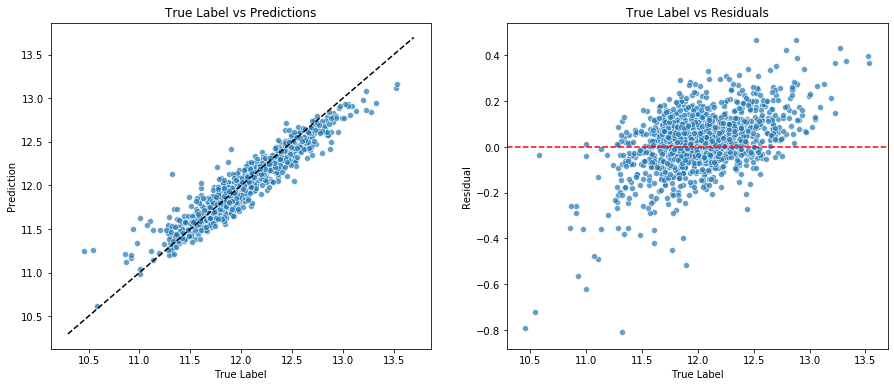

In [14]:
plot_predictions(train_set, y, lasso_oof)

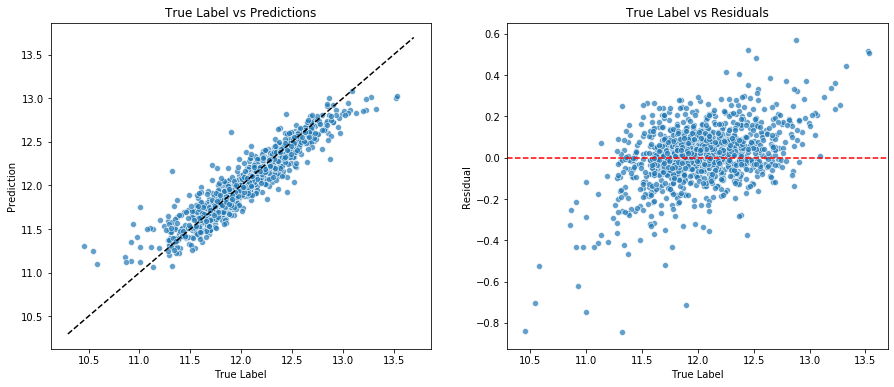

In [15]:
plot_predictions(train_set, y, forest_oof)

At last, I want to see some metrics and the residual plots for the most important features

In [22]:
def evaluate(data, y_true, y_pred, pipe, feat='coef', hue=None, legend=False, savename='test.png'):
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)}')
    print(f'MAE: {round(mean_absolute_error(np.expm1(y_true), np.expm1(y_pred)), 4)}')
    
    plot_predictions(data, y_true, y_pred, hue=hue, legend=legend, savename=savename)
    
    if feat=='coef':
        imp_feat = get_coef(pipe)
    elif feat == 'imp':
        imp_feat = get_feature_importance(pipe)
    else:
        raise AttributeError('The attribute feat can either be coef or imp')
        
    imp_feat['abs'] = abs(imp_feat['score'])
    imp_feat = imp_feat.sort_values(by='abs', ascending=False).head()
    
    if savename.endswith('.png'):
        savename = savename.replace('.png', '_')
    
    for feat in imp_feat.feat:
        feat_savename = savename + feat + '.png'
        try:
            plot_predictions(data, y_true, y_pred, feature=feat,
                         hue=hue, legend=legend, savename=feat_savename)
        except (KeyError, ValueError):
            print(f'{feat} not present in the provided data, probably is generated by a transformation in the pipeline')

RMSE: 0.1336
MAE: 17848.4668
service_area not present in the provided data, probably is generated by a transformation in the pipeline


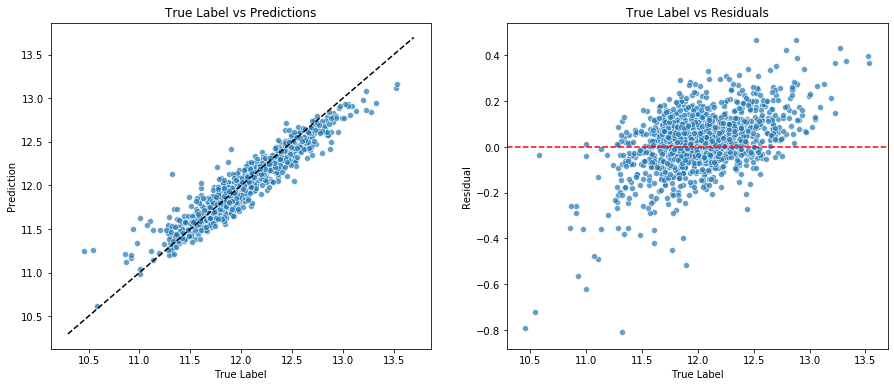

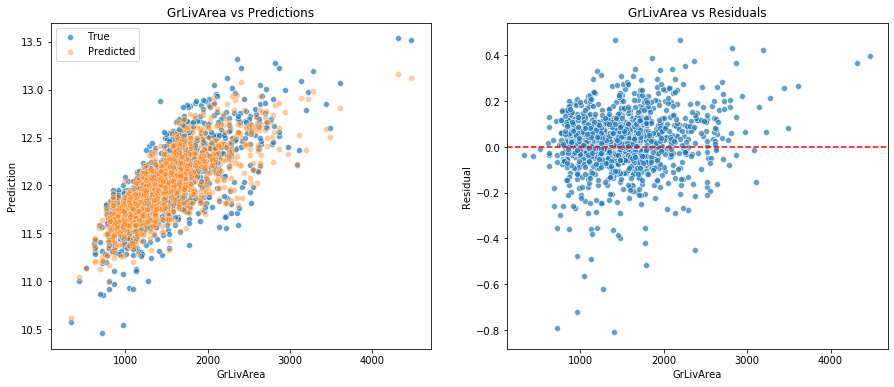

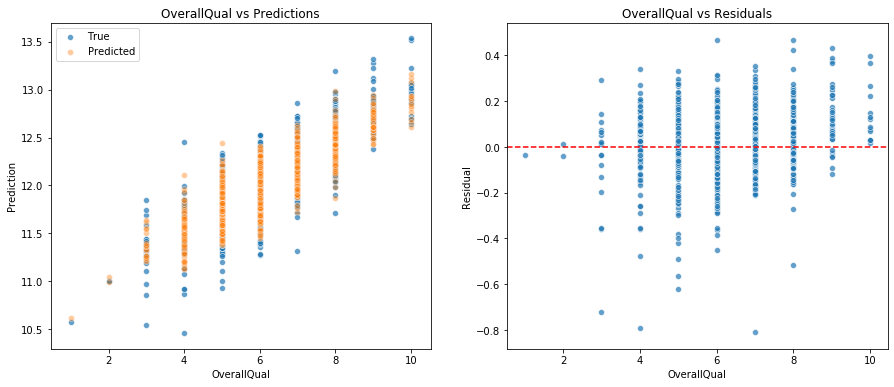

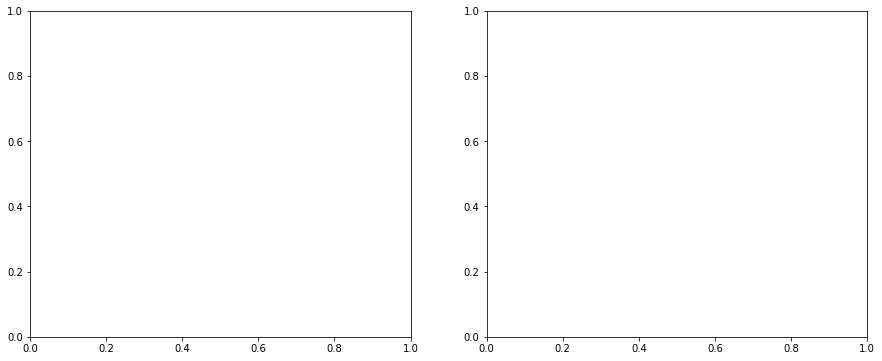

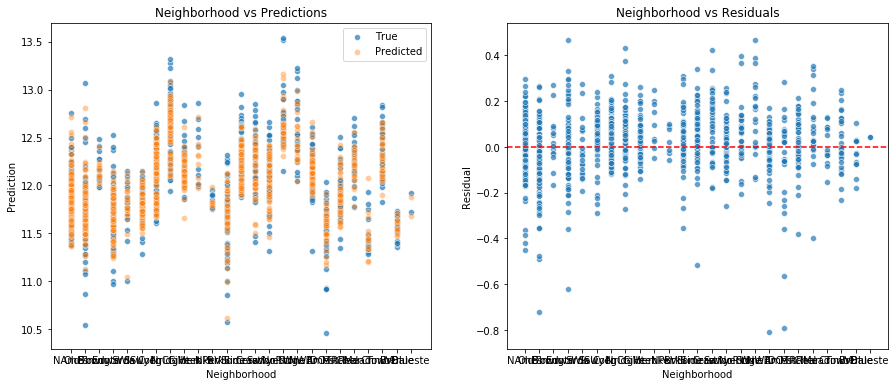

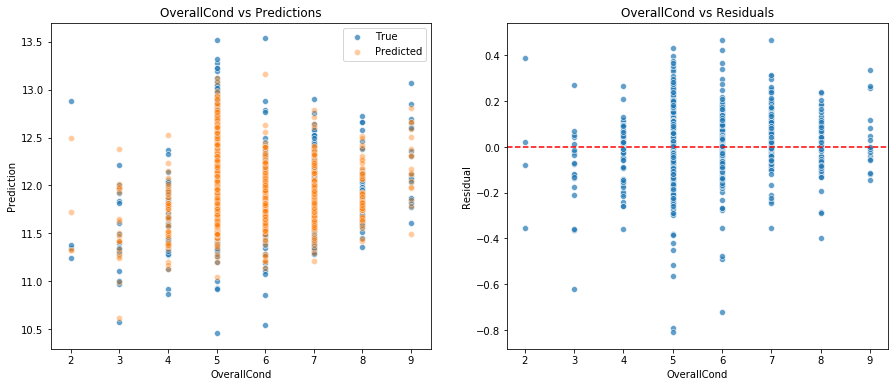

In [23]:
evaluate(train_set, y, lasso_oof, lasso_pipe)

RMSE: 0.1424
MAE: 18099.6405


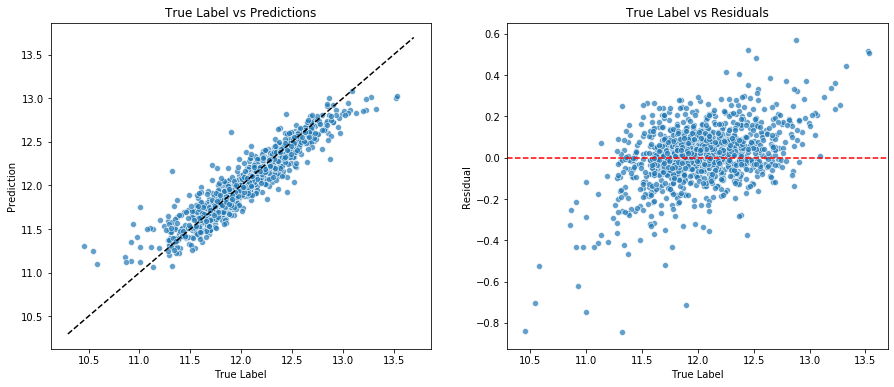

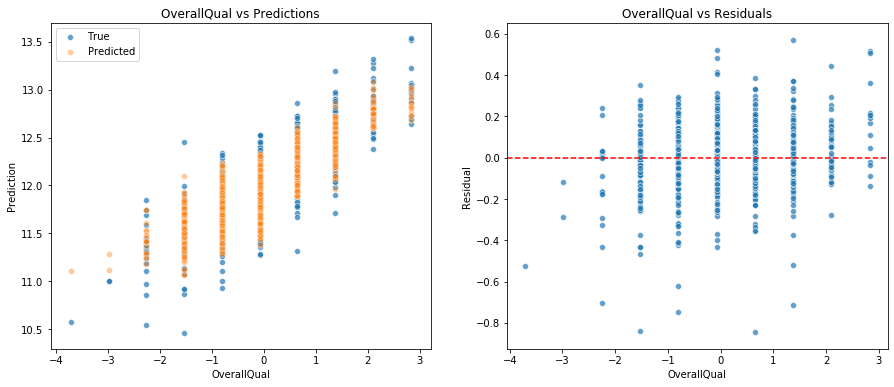

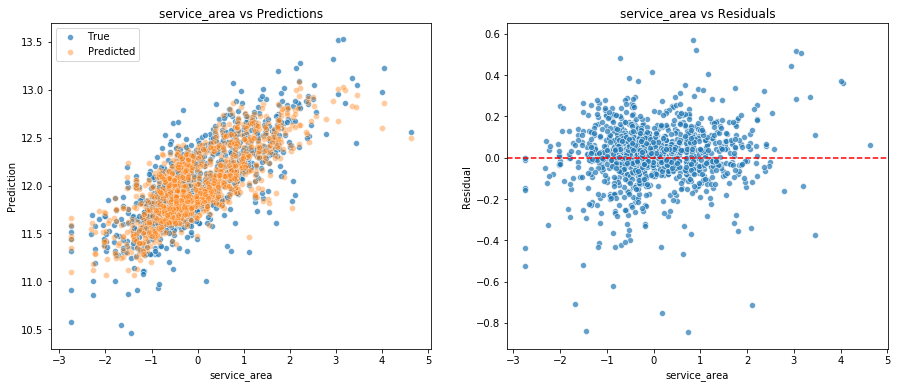

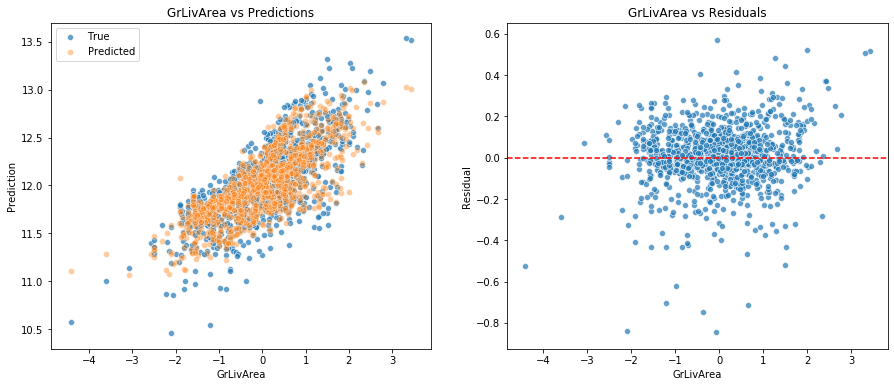

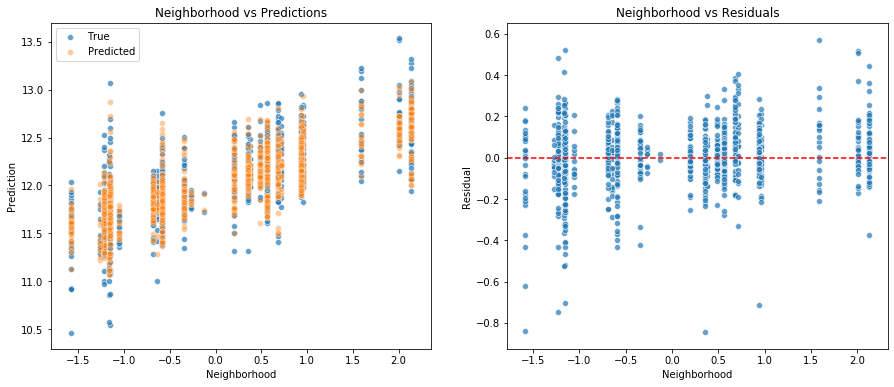

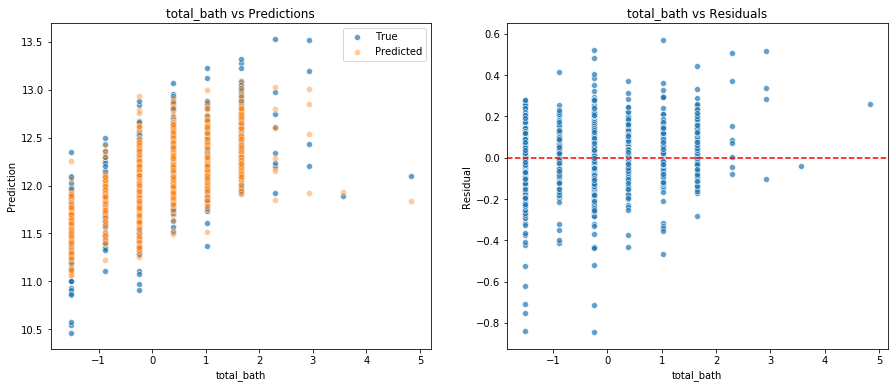

In [25]:
feat_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', dfp.df_scaler())])
tmp = train_set.copy()
tmp = feat_pipe.fit_transform(tmp, y)

evaluate(tmp, y, forest_oof, forest_pipe, feat='imp')

At last, it might be useful to see the performance on the validation set. The good news is that our functions will do just that.

../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)


RMSE: 0.1427
MAE: 17550.7728
service_area not present in the provided data, probably is generated by a transformation in the pipeline


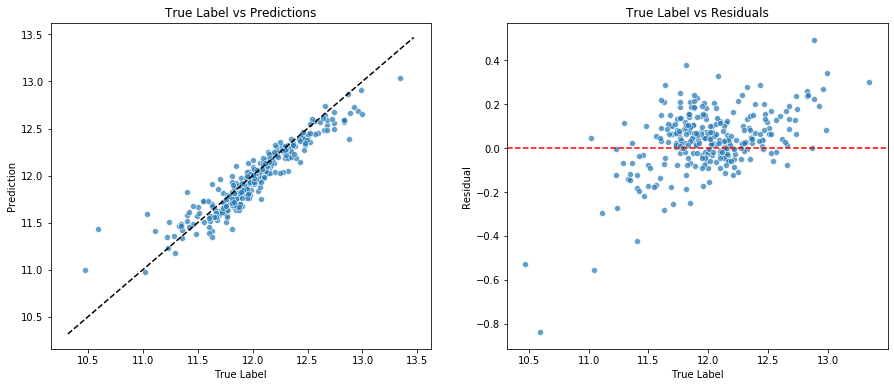

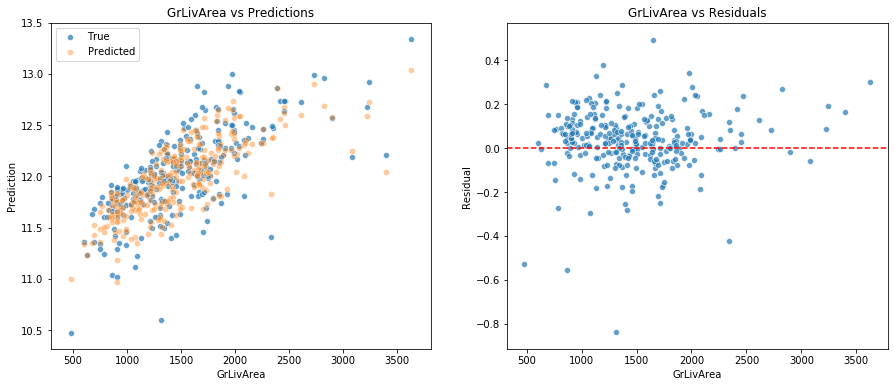

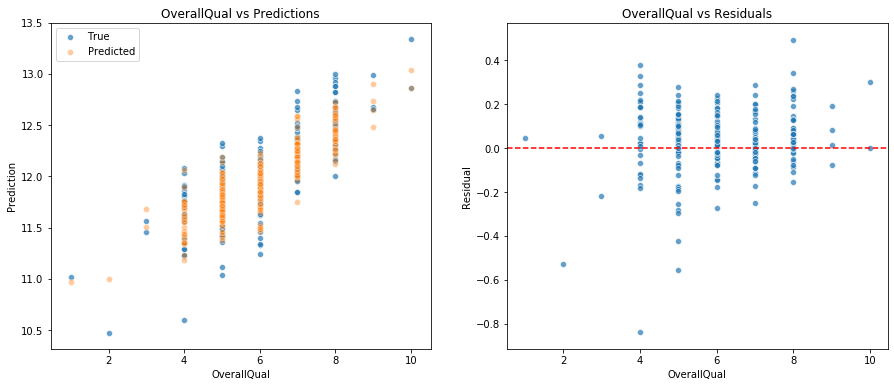

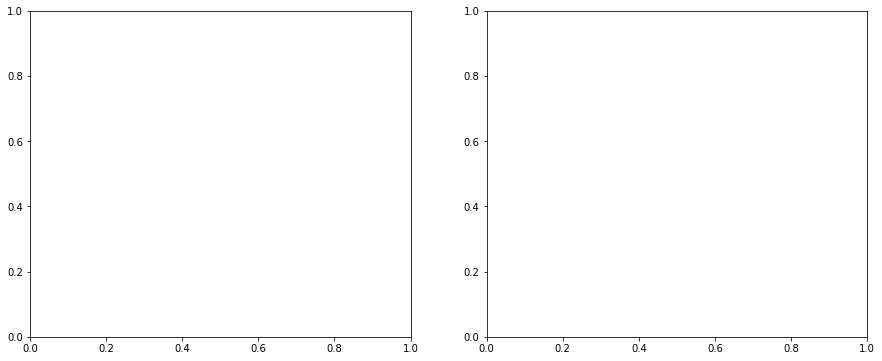

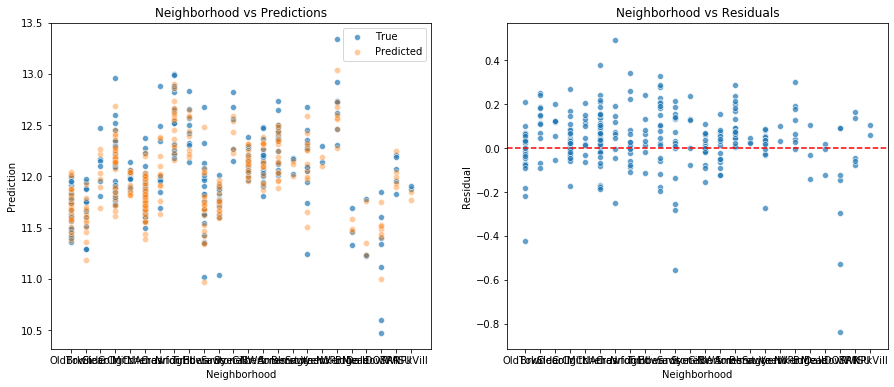

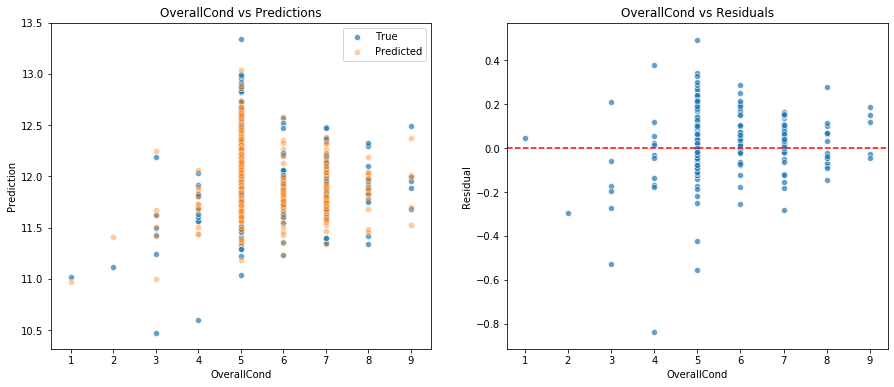

In [26]:
lasso_pred = lasso_pipe.predict(test_set)

evaluate(test_set, y_test, lasso_pred, lasso_pipe)

Staying on our training set, we can use it to tune the hyperparameters via GridSearch

In [27]:
def grid_search(data, target, estimator, param_grid, scoring, cv):
    
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    splits = result[[col for col in result.columns if col.startswith('split')]].head()
    splits.columns = [col.split('_test')[0] for col in splits.columns]
    
    splits.T.plot(alpha=0.5, figsize=(12,8))
    plt.savefig('../plots/gridsearch.png')
    plt.close()
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_, grid.best_estimator_

In [28]:
res, bp, best_est = grid_search(train_set, y, lasso_pipe,
                                param_grid={'processing__num_pipe__transf__SF_room': [True, False], 
                        'processing__num_pipe__transf__service': [True, False],
                                            'processing__cat_pipe__recode__mean_weight': [1, 10, 20, 100],
                        'lasso__alpha': [0.1, 0.01, 0.001]},
                                cv=folds, scoring='neg_mean_squared_error')

res.head(10)

,param_lasso__alpha,param_processing__cat_pipe__recode__mean_weight,param_processing__num_pipe__transf__SF_room,param_processing__num_pipe__transf__service,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.001,1,True,True,-0.018539,0.002912,0.162624,0.005283,0.101599,0.002070
1,0.001,1,False,True,-0.018570,0.002919,0.159089,0.003962,0.100160,0.001129
2,0.001,10,True,True,-0.018644,0.003019,0.158689,0.001735,0.100718,0.001464
3,0.001,10,False,True,-0.018695,0.003035,0.156638,0.002612,0.100495,0.001947
4,0.001,20,True,True,-0.018833,0.003111,0.161150,0.003139,0.112914,0.011542
5,0.001,20,False,True,-0.018893,0.003136,0.180095,0.009189,0.104456,0.004513
6,0.001,1,True,False,-0.018981,0.002832,0.164592,0.010327,0.100705,0.002084
7,0.001,10,True,False,-0.018999,0.002657,0.158150,0.002412,0.100535,0.002399
8,0.001,1,False,False,-0.019003,0.002842,0.161504,0.004674,0.099843,0.002283
9,0.001,10,False,False,-0.019036,0.002672,0.156803,0.002194,0.102251,0.001549


In [29]:
bp

{'lasso__alpha': 0.001,
 'processing__cat_pipe__recode__mean_weight': 1,
 'processing__num_pipe__transf__SF_room': True,
 'processing__num_pipe__transf__service': True}

In [30]:
best_est.predict(df_test)

../source/transf_univ.py:125: UserWarning: The dummies in this set do not match the ones in the train set, we corrected the issue.
  UserWarning)


array([11.72324822, 11.94072124, 12.08073757, ..., 12.07099424,
       11.65663944, 12.29028747])

# Learning Curves

A valuable tool to evaluate a model is to use learning curves.

TO be continued